# Financial data science and hedging

#### Job Marcelis, Ernani Hazbolatow, Koen Verlaan

In [24]:
from src.hedging_sim import *
from src.volatility import *
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from skfolio.datasets import load_sp500_dataset, load_sp500_implied_vol_dataset


#### 1. Realized and Implied Volatility
After importing the data using yfinance, we'll start with the classical estimators for drift (μ) and volatility (σ).

The drift estimator is given by:

$$\hat{\mu}_N = \frac{1}{N} \sum_{k=0}^{N-1} \frac{1}{t_{k+1}-t_k} \left(\frac{S^M_{t_{k+1}}-S^M_{t_k}}{S^M_{t_k}}\right)$$

And the volatility estimator is:

$$\hat{\sigma}^2_N = \frac{1}{N-1} \sum_{k=0}^{N-1} \frac{1}{t_{k+1}-t_k} \left(\frac{S_{t_{k+1}}-S_{t_k}}{S_{t_k}} - (t_{k+1}-t_k)\hat{\mu}_N\right)^2$$

After, we'll implement the Parkinson and Garman-Klass estimators.

##### Parkinson Estimator
$$\sigma_{Parkinson} = \sqrt{\frac{1}{4\ln(2)T} \sum_{t=1}^T \ln\left(\frac{H_t}{L_t}\right)^2}$$

where $H_t$ and $L_t$ are the high and low prices on day $t$.

##### Garman-Klass Estimator
$$\sigma_{GK} = \sqrt{\frac{1}{2T} \sum_{t=1}^T \ln\left(\frac{H_t}{L_t}\right)^2 - \frac{2\ln(2)-1}{T} \sum_{t=1}^T \ln\left(\frac{C_t}{O_t}\right)^2}$$

where $O_t$ and $C_t$ are the opening and closing prices on day $t$.

In [25]:
# Set parameters
ticker = 'AAPL'
start_date = "2020-01-01"
end_date = "2025-01-01"

# Download data``
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

[*********************100%***********************]  1 of 1 completed



In [26]:
# Calculate returns
returns = calculate_returns(data['Close'])

# Calculate drift
mu_hat = calculate_drift(returns)
print(f"Estimated μ (drift): {mu_hat:.6f}")

# Calculate classical volatility
vol_hat = calculate_classical_volatility(returns, mu_hat)
print(f"\nEstimated σ (volatility): {vol_hat:.6f}")

# Calculate Parkinson volatility
sigma_parkinson = calculate_parkinson_volatility(data['High'], data['Low'])
print(f"Parkinson volatility estimator: {sigma_parkinson:.6f}")
print(f"Annualized Parkinson volatility: {sigma_parkinson * np.sqrt(252):.6f}")

# Calculate Garman-Klass volatility
sigma_gk = calculate_garman_klass_volatility(
    data['High'], data['Low'], data['Open'], data['Close']
)
print(f"\nGarman-Klass volatility estimator: {sigma_gk:.6f}")
print(f"Annualized Garman-Klass volatility: {sigma_gk * np.sqrt(252):.6f}")

# Create comparison DataFrame
comparison_df = create_volatility_comparison_df(vol_hat, sigma_parkinson, sigma_gk)
print("\nVolatility Estimator Comparison:")
comparison_df

Estimated μ (drift): 0.001182

Estimated σ (volatility): 0.019956
Parkinson volatility estimator: 0.015445
Annualized Parkinson volatility: 0.245186

Garman-Klass volatility estimator: 0.015455
Annualized Garman-Klass volatility: 0.245341

Volatility Estimator Comparison:


,Estimator,Value,Annualized (%)
0,Classical,0.019956,31.678650
1,Parkinson,0.015445,24.518588
2,Garman-Klass,0.015455,24.534076


##### Rolling Window Analysis

We'll now calculate rolling window estimators using a 30-day window to observe how volatility changes over time.

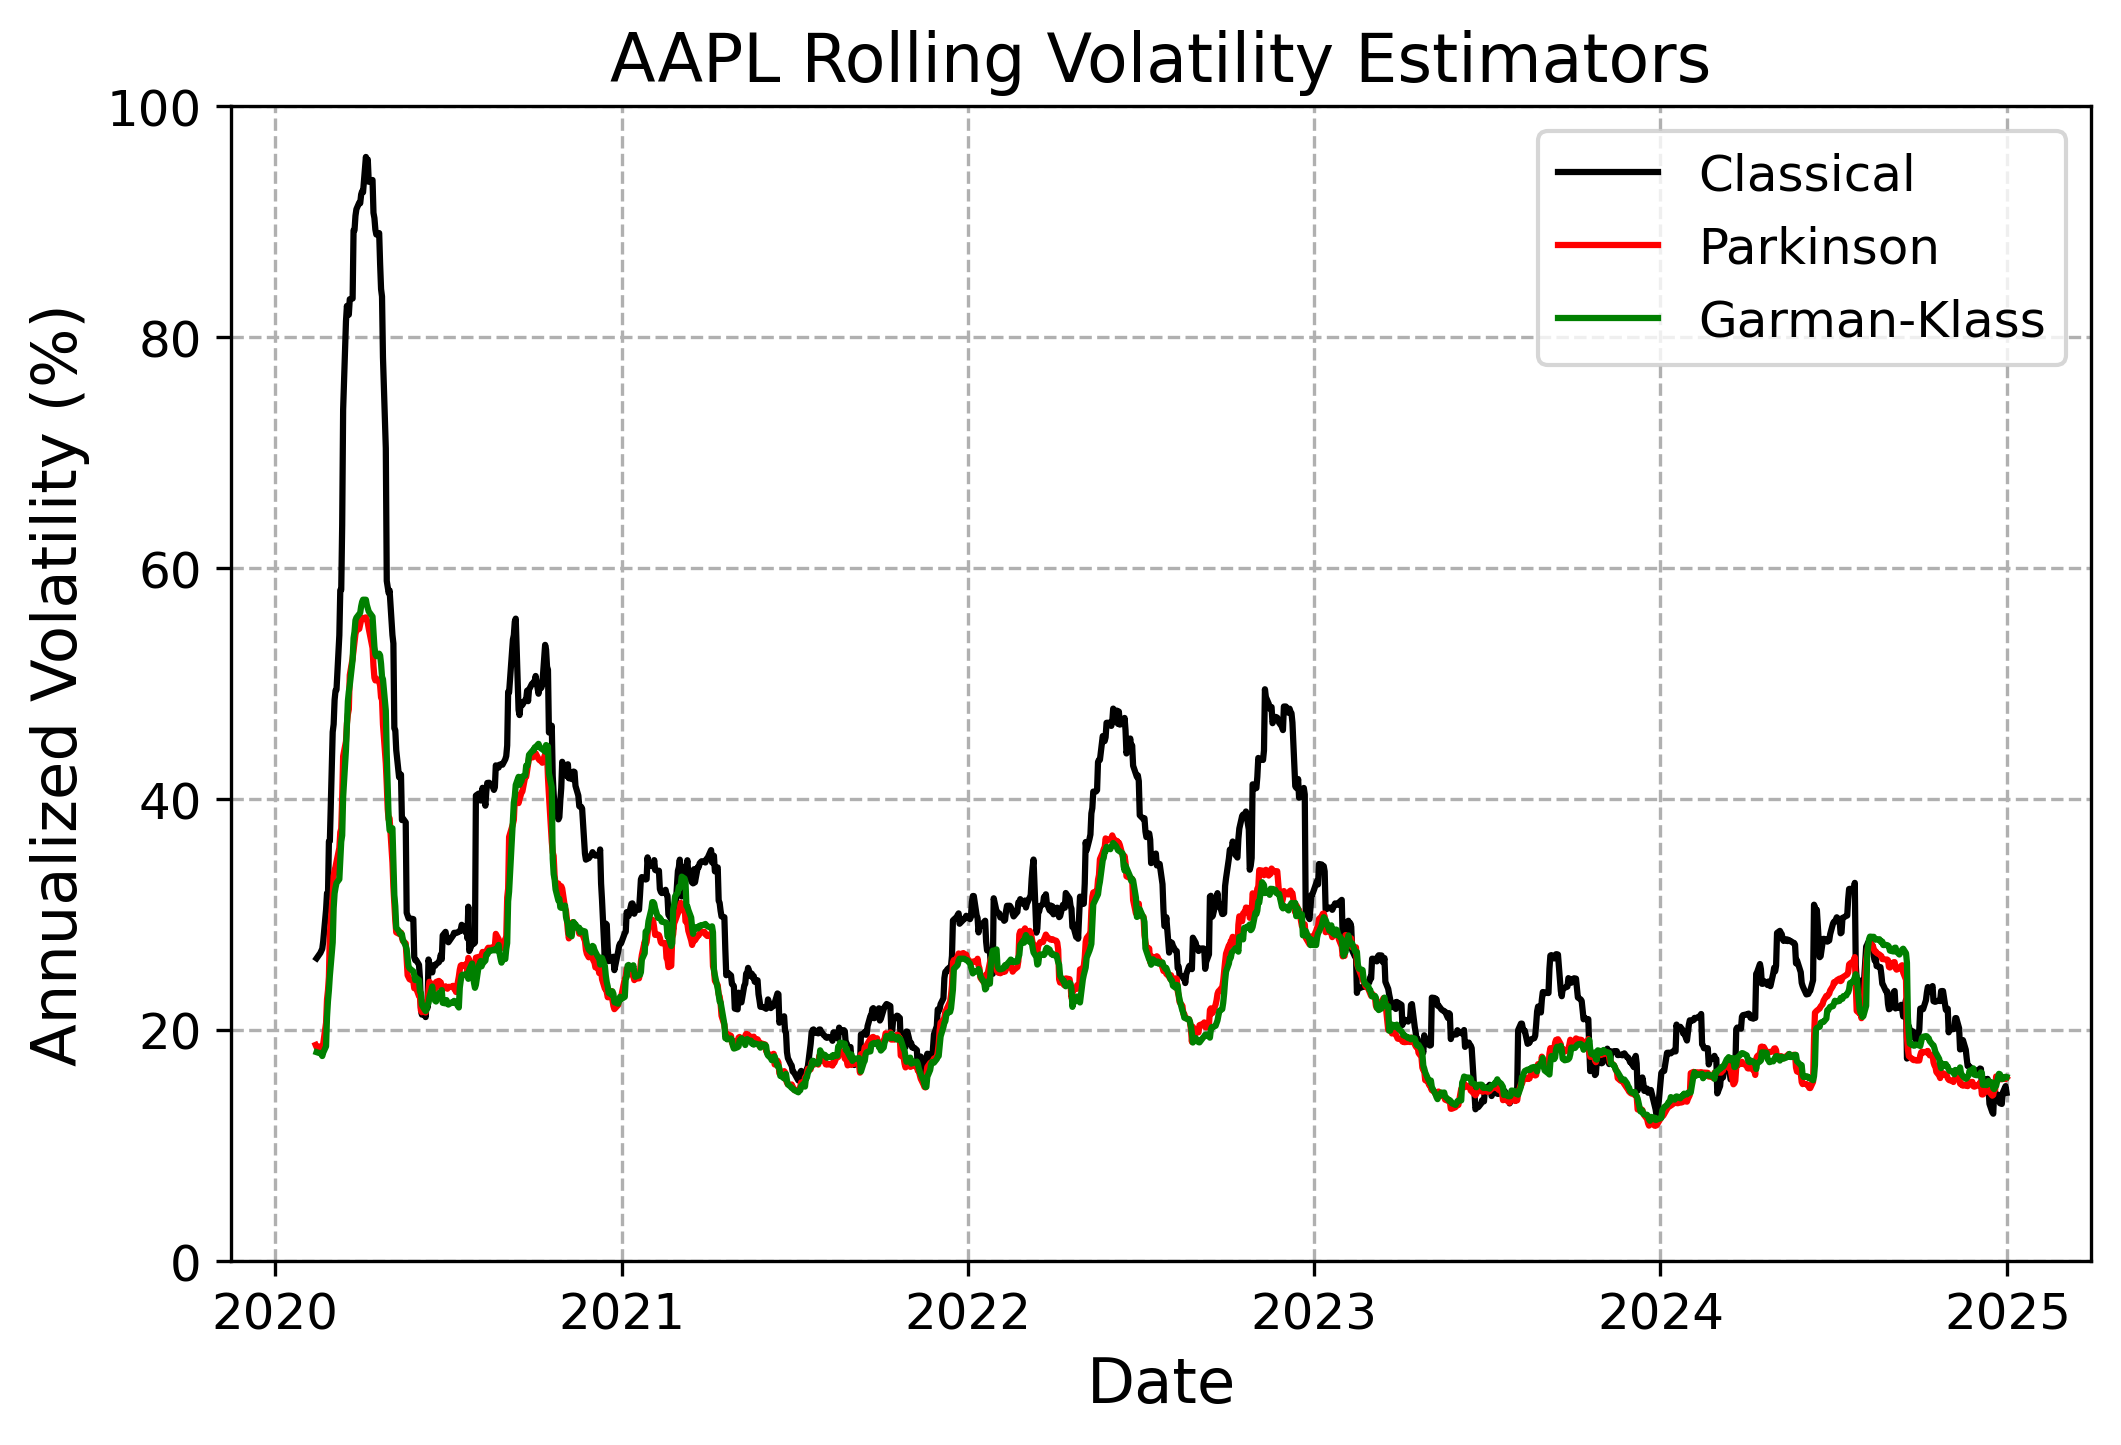

In [27]:
window = 30

# Calculate rolling volatility estimators
rolling_std = calculate_rolling_volatility(returns, window)
rolling_parkinson = calculate_rolling_parkinson(data['High'], data['Low'], window)
rolling_gk = calculate_rolling_garman_klass(data, window)

# Plot the rolling volatility estimators
fig = plot_rolling_volatility(rolling_std, rolling_parkinson, rolling_gk, 'AAPL')
plt.show()

##### Realized vs Implied Analysis

Now we'll compare our realized volatility estimators with implied volatilities from the market. This provides insights into how market expectations align with historical volatility patterns.

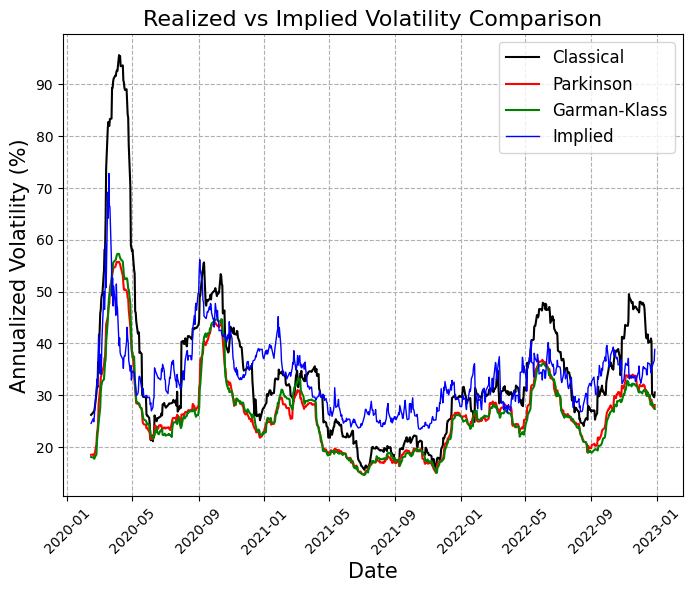

In [ ]:
# Load S&P 500 datasets
prices = load_sp500_dataset()
impliedvol = load_sp500_implied_vol_dataset()

# Filter for our analysis period
prices = prices.loc["2010":]
impliedvol = impliedvol.loc[prices.index]

# Calculate realized volatility for comparison
window = 30 
realized_vol = pd.DataFrame(index=prices.index)

# Calculate realized volatility for each estimator
realized_vol['Classical'] = rolling_std
realized_vol['Parkinson'] = rolling_parkinson
realized_vol['Garman-Klass'] = rolling_gk

# Merge with implied volatility data
vol_comparison = pd.merge(
    realized_vol,
    impliedvol,
    left_index=True,
    right_index=True,
    how='inner'
).dropna()

# Plot comparison with updated colors
plt.figure(figsize=(8, 6))
plt.plot(vol_comparison.index, vol_comparison['Classical'], 
         label='Classical', color=COLORS['primary'])
plt.plot(vol_comparison.index, vol_comparison['Parkinson'], 
         label='Parkinson', color=COLORS['secondary'])
plt.plot(vol_comparison.index, vol_comparison['Garman-Klass'], 
         label='Garman-Klass', color=COLORS['tertiary'])
plt.plot(vol_comparison.index, vol_comparison[ticker]*100, 
         label='Implied', color=COLORS['quaternary'], linewidth=1)

plt.title('Realized vs Implied Volatility Comparison', fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Annualized Volatility (%)', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True, ls='dashed')
plt.xticks(rotation=45)
plt.show()

##### Vix 
First, we'll download VIX data for the specified time window.

In [29]:
# Set date parameters for VIX data
spx_symbol = "^SPX"
end_date = datetime.datetime.strptime("2025-04-03", "%Y-%m-%d") 
start_date = end_date - datetime.timedelta(days=365)

# Download SPX data
spx_data = download_stock_data(spx_symbol, 
                                  start_date.strftime("%Y-%m-%d"), 
                                  end_date.strftime("%Y-%m-%d"))

lastBusDay = spx_data.index[-1]
vix_data = download_vix_data(lastBusDay, lastBusDay + datetime.timedelta(days=1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Now we'll analyze option chain data for the S&P 500 index.

In [30]:
calls_df, puts_df, _ = get_option_chain(spx_symbol)

print("Calls Head:")
print(calls_df.head())

print("\nPuts Head:")
print(puts_df.head())

Calls Head:
   Unnamed: 0       contractSymbol              lastTradeDate  strike  \
0           0  SPXW250403C02800000  2025-04-03 02:35:56+00:00  2800.0   
2           2  SPXW250403C05150000  2025-04-03 02:48:42+00:00  5150.0   
3           3  SPXW250403C05200000  2025-04-03 16:40:04+00:00  5200.0   
4           4  SPXW250403C05400000  2025-04-03 17:15:38+00:00  5400.0   
5           5  SPXW250403C05420000  2025-04-03 17:15:39+00:00  5420.0   

      Last     bid     ask     change  percentChange  volume  openInterest  \
0  2713.28  2643.4  2661.6 -183.11987      -6.322327     1.0             1   
2   366.97   296.5   304.2  -96.91000     -20.891178     1.0             3   
3   264.90   255.3   256.1 -193.66000     -42.232204    68.0             5   
4    57.10    58.5    59.1 -213.60000     -78.906530  2890.0            12   
5    40.93    39.0    39.5 -141.98001     -77.622880  2190.0             7   

   impliedVolatility  inTheMoney contractSize currency      expiry      mid  
0 

##### VIX Estimation

We'll estimate the VIX using the CBOE methodology:

$$VIX_t = \sqrt{\frac{2e^{r\tau}}{\tau} \left(\int_0^F \frac{P(t,t+\tau,K)}{K^2}dK + \int_F^\infty \frac{C(t,t+\tau,K)}{K^2}dK\right)}$$

where:
- $\tau$ is time to expiration (30 days)
- $r$ is the risk-free rate
- $F$ is the forward index level
- $P$ and $C$ are put and call option prices

In [31]:
# Calculate the VIX index
try:
    # Parameters
    risk_free_rate = 0.02
    tau = 30/365  # 30 days in years
    S_t = spx_data['Close'].iloc[-1].item()
    
    # Calculate forward price
    F_t_tau = calculate_forward_price(S_t, risk_free_rate, tau)
    
    print(f"Current SPX price (S_t): {S_t:.2f}")
    print(f"Forward price (F_t,t+τ): {F_t_tau:.2f}")
    
    # Filter OTM options
    otm_puts, otm_calls = filter_otm_options(puts_df, calls_df, F_t_tau)
    
    print(f"Number of OTM puts: {len(otm_puts)}")
    print(f"Number of OTM calls: {len(otm_calls)}")
    
    # Calculate VIX
    estimated_vix = calculate_vix(otm_puts, otm_calls, risk_free_rate, tau)
    
    print(f"Estimated VIX: {estimated_vix:.2f}%")
    
    # Compare with CBOE-quoted VIX
    try:
        cboe_vix = vix_data['Close'].iloc[0].item()
        print(f"CBOE-quoted VIX: {cboe_vix:.2f}%")
        print(f"Difference: {abs(estimated_vix - cboe_vix):.2f}%")
    except (IndexError, KeyError) as e:
        print(f"Error accessing VIX data: {e}")
        print("CBOE-quoted VIX: Not available")
        
except Exception as e:
    print(f"Error calculating VIX: {e}")

Current SPX price (S_t): 5670.97
Forward price (F_t,t+τ): 5680.30
Number of OTM puts: 105
Number of OTM calls: 56
Estimated VIX: 14.64%
CBOE-quoted VIX: 21.51%
Difference: 6.87%


Now we'll compare realized volatility with the VIX and analyze their relationship.

[*********************100%***********************]  1 of 1 completed


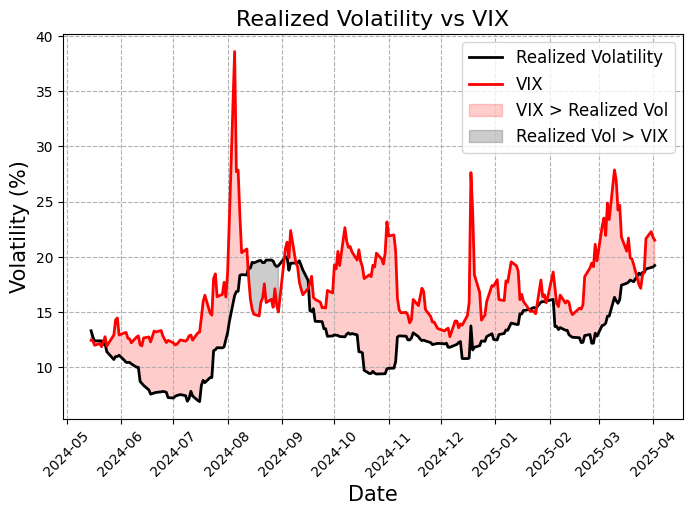

In [ ]:
# Download historical VIX data for comparison
historical_vix = download_vix_data(
    start_date.strftime("%Y-%m-%d"), 
    end_date.strftime("%Y-%m-%d")
)

# Calculate historical realized variance
window = 30 
spx_returns = calculate_returns(spx_data['Close'])
rolling_variance = spx_returns.rolling(window=window).var() * 252  
rolling_volatility = np.sqrt(rolling_variance) * 100 

# Create DataFrames for comparison
realized_vol_df = pd.DataFrame(rolling_volatility)
realized_vol_df.columns = ['Realized Volatility']

vix_df = pd.DataFrame(historical_vix['Close'])
vix_df.columns = ['VIX']

# Merge the DataFrames
volatility_df = pd.merge(
    realized_vol_df, vix_df, 
    left_index=True, right_index=True, 
    how='inner'
).dropna()

# Plot comparison with updated colors and consistent y-axis
plt.figure(figsize=(8, 5))
plt.plot(volatility_df.index, volatility_df['Realized Volatility'], 
         label='Realized Volatility', linewidth=2, color=COLORS['primary'])
plt.plot(volatility_df.index, volatility_df['VIX'], 
         label='VIX', linewidth=2, color=COLORS['secondary'])

# Add shaded area for difference
plt.fill_between(volatility_df.index, 
                 volatility_df['Realized Volatility'], 
                 volatility_df['VIX'],
                 where=(volatility_df['VIX'] > volatility_df['Realized Volatility']),
                 color=COLORS['secondary'], alpha=0.2,
                 label='VIX > Realized Vol')
plt.fill_between(volatility_df.index,
                 volatility_df['Realized Volatility'],
                 volatility_df['VIX'],
                 where=(volatility_df['VIX'] <= volatility_df['Realized Volatility']),
                 color=COLORS['primary'], alpha=0.2,
                 label='Realized Vol > VIX')

plt.title('Realized Volatility vs VIX', fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Volatility (%)', fontsize=15)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(True, ls='dashed')
plt.show()

Finally, we'll perform statistical analyses to understand the relationship between returns and volatility.

In [33]:
# Calculate correlation
correlation = calculate_correlation(
    volatility_df['Realized Volatility'], 
    volatility_df['VIX']
)
print(f"Correlation between Realized Volatility and VIX: {correlation:.4f}")

# Perform cointegration test
coint_result = test_cointegration(
    volatility_df['Realized Volatility'], 
    volatility_df['VIX']
)
print(f"Cointegration test p-value: {coint_result[1]:.4f}")
if coint_result[1] < 0.05:
    print("The series are cointegrated (p < 0.05)")
else:
    print("The series are not cointegrated (p >= 0.05)")

Correlation between Realized Volatility and VIX: 0.4302
Cointegration test p-value: 0.4626
The series are not cointegrated (p >= 0.05)


In [34]:
spx_returns.index = pd.to_datetime(spx_returns.index)
volatility_df.index = pd.to_datetime(volatility_df.index)
spx_returns = spx_returns['^SPX']

In [35]:
vix_reg_results, vix_corr = analyze_spx_vix_relationship(spx_returns, volatility_df['VIX'])
vol_reg_results, vol_corr = analyze_returns_volatility_relationship(spx_returns, volatility_df['Realized Volatility'])

volatility_df['SPX Returns'] = spx_returns

print("\nKey Statistics:")
print(f"Correlation between SPX returns and VIX changes: {vix_corr:.4f}")
print(f"Correlation between SPX returns and volatility changes: {vol_corr:.4f}")
print(f"R-squared (VIX regression): {vix_reg_results.rsquared:.4f}")
print(f"R-squared (Volatility regression): {vol_reg_results.rsquared:.4f}")


Key Statistics:
Correlation between SPX returns and VIX changes: -0.8047
Correlation between SPX returns and volatility changes: -0.2437
R-squared (VIX regression): 0.6475
R-squared (Volatility regression): 0.0594


#### 3. Hedging Simulation

The euler method is used to make a simple hedging simulation. The stock price movement is thus modeled according to the following equation:
\begin{equation}
    S_{t + dt} = S_t + rS_tdt + \sigma S_t\sqrt{dt}Z,
\end{equation}
where $r$ is the risk-free interest rate, $\sigma$ is the volatility, and $Z$ is a standard normal variable.

Furthermore, $\Delta$ is calculated using: $N(d_1)$, where $N$ is the cumulative distribution function of the standard normal distribution and $d_1$ is given by:
\begin{equation}
    d_1 = \frac{ln(\frac{S}{K}) + (r + \frac{\sigma ^2}{2})T}{\sigma \sqrt{T}},
\end{equation}
where $K$ is the strike price and $T$ is the time. And the option price is given by:
\begin{equation}
    C(S_t, K, t, T, \sigma) = S_tN(d_1) - Ke^{-rT}N(d_2),
\end{equation}
where $d_2 = d_1 - \sigma \sqrt{T}$.

The hedging simulation works as follows:
- A price path is calculated using the euler approximation of the Black-Scholes equation
- At each step in this path, the $\Delta$ calculated, the interest rate is added, and the change in stock position is calculated
- At maturity, the payoff of the option, followed by the value of the portfolio, and the hedging error, is calculated.

This process is repeated 5000 times and the mean and confidence intervals at the $p=95%$ confidence level are calculated.

In the first experiment, we match the volatility of the price path with the option delta and vary the hedge adjustment frequency:

In [36]:
more_freqs = np.linspace(12, 330, 11)
means = []
CIs = []
for i in more_freqs:
    mean, CI = multiple_hedge_sims(num_runs=5000, S0=100, r=0.06, sigma=0.2, sigma_delta=0.2, T=1, dt=1/i, K=99, seed=int(i))
    means.append(mean)
    CIs.append(CI)

mean_weekly, CI_weekly = multiple_hedge_sims(num_runs=5000, S0=100, r=0.06, sigma=0.2, sigma_delta=0.2, T=1, dt=1/52, K=99, seed=52)
mean_daily, CI_daily = multiple_hedge_sims(num_runs=5000, S0=100, r=0.06, sigma=0.2, sigma_delta=0.2, T=1, dt=1/365, K=99, seed=365)

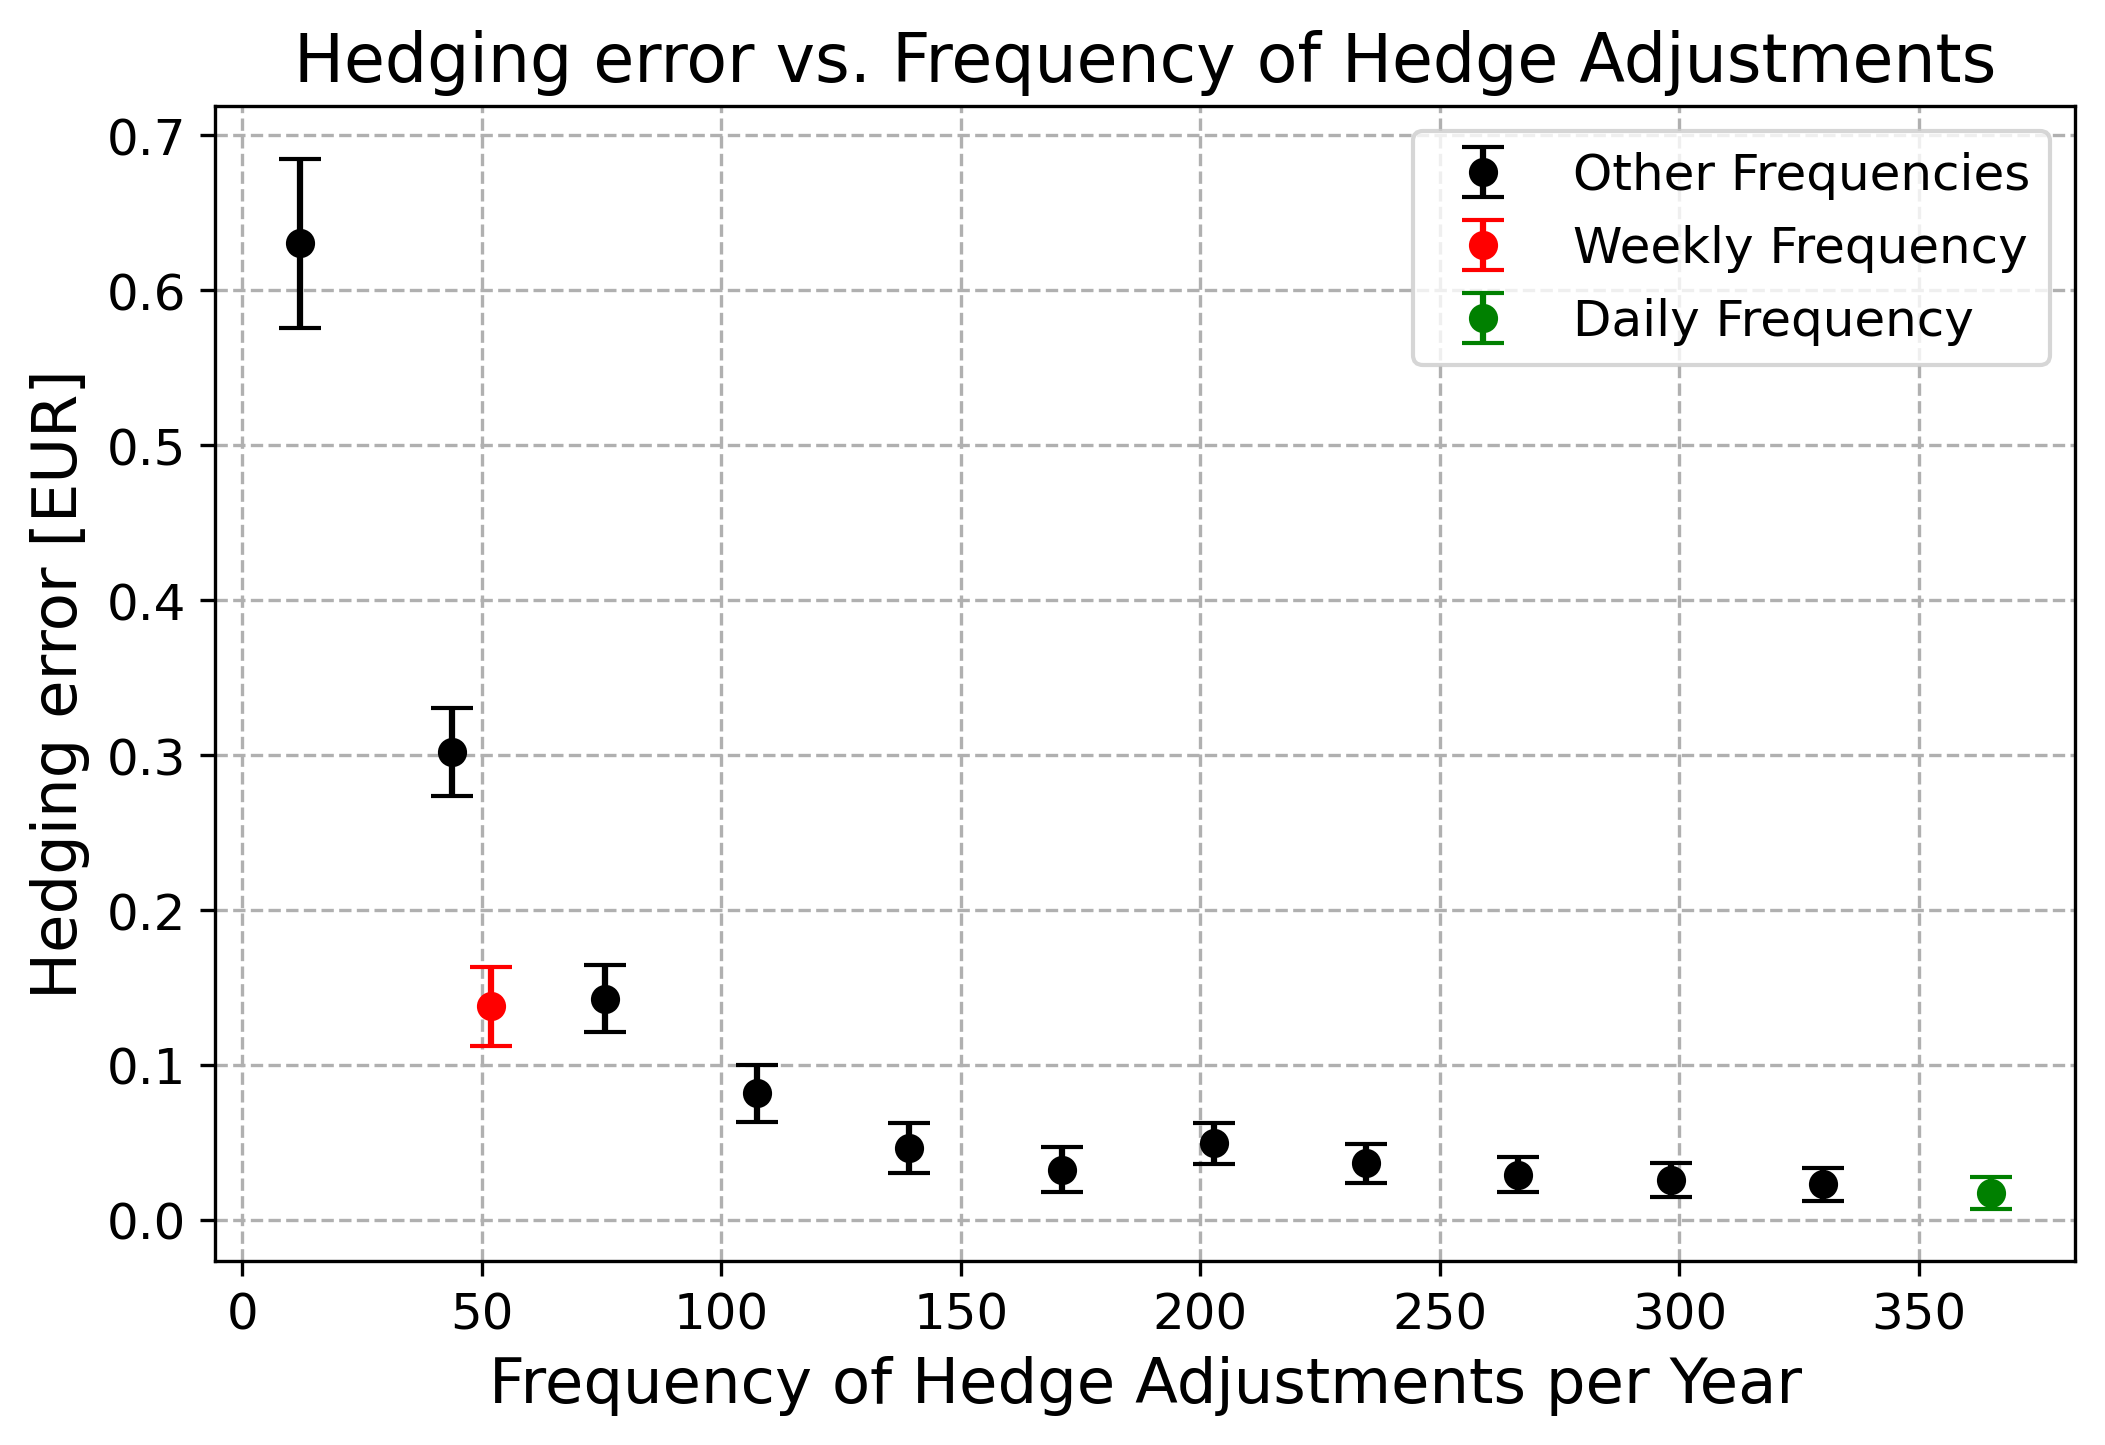

In [37]:
plt.figure(figsize=(8,5), dpi=300)
plt.title("Hedging error vs. Frequency of Hedge Adjustments", fontsize=16)
plt.errorbar(more_freqs, means, yerr=CIs, fmt='o', color='black', label='Other Frequencies', capsize=5)
plt.errorbar(52, mean_weekly, yerr=CI_weekly, fmt='o', color='red', label='Weekly Frequency', capsize=5)
plt.errorbar(365, mean_daily, yerr=CI_daily, fmt='o', color='green', label='Daily Frequency', capsize=5)
plt.ylabel("Hedging error [EUR]", fontsize=15)
plt.xlabel("Frequency of Hedge Adjustments per Year", fontsize=15)
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)
plt.grid(ls='dashed')
plt.show()

In the second experiment, the volatility of the price path is fixed while the volatility of the option delta is varied:

In [38]:
delta_val_volatility = np.linspace(10, 30, 10)
means = []
CIs = []
for i in delta_val_volatility:
    mean, CI = multiple_hedge_sims(num_runs=5000, S0=100, r=0.06, sigma=0.2, sigma_delta=i/100, T=1, dt=1/365, K=99, seed=int(i*i))
    means.append(mean)
    CIs.append(CI)
mean_matched, CI_matched = multiple_hedge_sims(num_runs=5000, S0=100, r=0.06, sigma=0.2, sigma_delta=20/100, T=1, dt=1/365, K=99, seed=69)

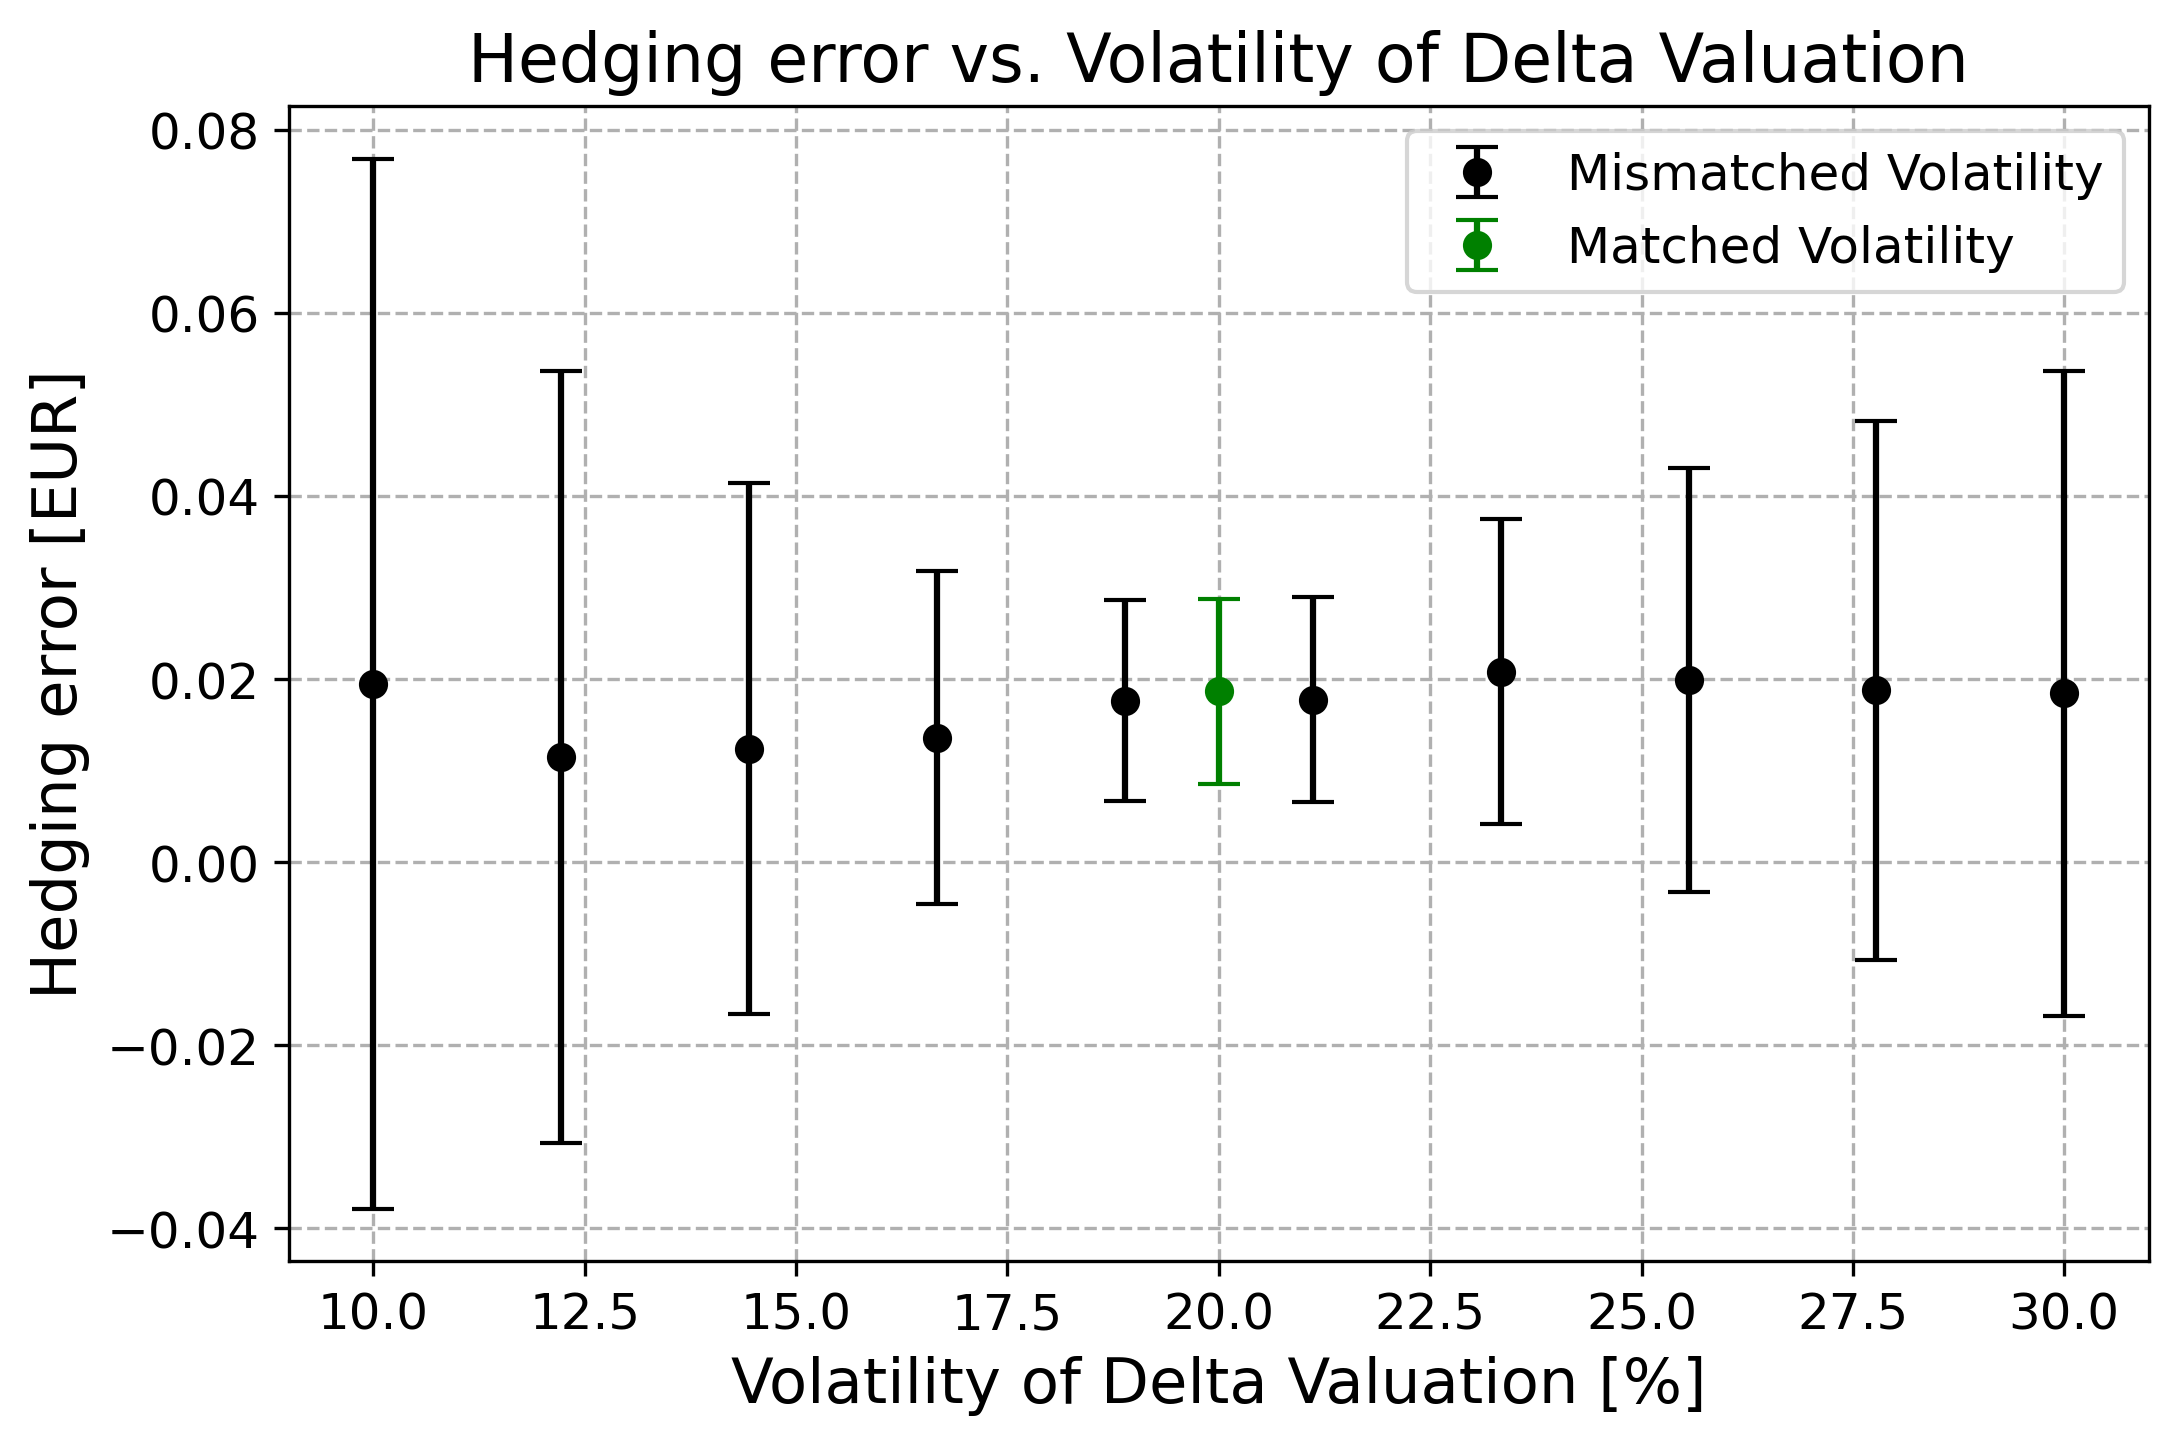

In [39]:
plt.figure(figsize=(8,5), dpi=300)
plt.title("Hedging error vs. Volatility of Delta Valuation", fontsize=16)
plt.errorbar(delta_val_volatility, means, yerr=CIs, fmt='o', color='black', capsize=5, label='Mismatched Volatility')
plt.errorbar(20, mean_matched, yerr=CI_matched, fmt='o', color='green', capsize=5, label='Matched Volatility')
plt.ylabel("Hedging error [EUR]", fontsize=15)
plt.xlabel("Volatility of Delta Valuation [%]", fontsize=15)
plt.tick_params(axis='both', labelsize=12)
plt.grid(ls='dashed')
plt.legend(fontsize=12)
plt.show()